## Text Flappy Bird
**Romain Mondelice**

The goal of this assignment is to apply reinforcement learning methods to a
simple game called Text Flappy Bird (TFB). The game is a variation to the
well know Flappy Bird in which the player is made with a simple unit-element
character

---

## **General imports**

In [1]:
import os, sys
import gymnasium as gym
import time

import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pickle
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

import text_flappy_bird_gym

d:\anaconda\envs\CentraleSupelec\Lib\site-packages\seaborn\utils.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


---

## **Monte Carlo based agent**

In [2]:
class OffPolicyMonteCarloAgent:
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(self.zero_action_value)
        self.C = defaultdict(self.zero_action_value)
        self.target_policy = defaultdict(int)

    def zero_action_value(self):
        return np.zeros(self.env.action_space.n)
        
    def generate_episode(self, policy):
        episode = []
        state = self.env.reset()
        done = False
        while not done:
            # Convert state to a string representation.
            str_state = str(state)

            if str_state in policy:
                action_probs = policy[str_state]
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                # Fallback if the state is not in the policy, use uniform random selection
                action = self.env.action_space.sample()

            next_state, reward, done, _, info = self.env.step(action)
            episode.append((str_state, action, reward))
            state = next_state
        return episode
    
    def get_probs(self, Q_s, epsilon, nA):
        """Obtains the policy for a given state"""
        policy_s = np.ones(nA) * epsilon / nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / nA)
        return policy_s
    
    def update_Q(self, episode):
        G = 0.0
        W = 1.0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            self.C[state][action] += W
            self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])
            self.target_policy[state] = np.argmax(self.Q[state])
            
            if action != self.target_policy[state]:
                break
            W = W * 1./self.get_probs(self.Q[state], self.epsilon, self.env.action_space.n)[action]
            
    def train(self, num_episodes):
        for i_episode in range(1, num_episodes + 1):
            episode = self.generate_episode(policy=self.create_behavior_policy(self.Q))
            self.update_Q(episode)
    
    def create_behavior_policy(self, Q):
        """Creates a behavior policy using ε-greedy approach based on Q."""
        behavior_policy = {}
        for state, actions in Q.items():
            behavior_policy[state] = self.get_probs(actions, self.epsilon, self.env.action_space.n)
        return behavior_policy
    
    def get_state_value_function(self):
        state_value_function = {}
        for state, action_values in self.Q.items():
            state_value_function[state] = np.max(action_values)
        return state_value_function

In [3]:
def train_monte_carlo_agent(env_str, episodes=1000, gamma=0.9, epsilon=0.1):
    env = gym.make(env_str, height=15, width=20, pipe_gap=4)
    agent = OffPolicyMonteCarloAgent(env, gamma=gamma, epsilon=epsilon)
    
    episode_rewards = []  # List to store total reward from each episode

    for _ in tqdm(range(episodes), desc="Training process"):
        # Create the behavior policy from current Q
        behavior_policy = agent.create_behavior_policy(agent.Q)
        # Generate an episode using the behavior policy
        episode = agent.generate_episode(behavior_policy)
        # Update Q-values based on the episode
        agent.update_Q(episode)
        
        # Calculate total reward for the episode and store it
        total_reward = sum([reward for (_, _, reward) in episode])
        episode_rewards.append(total_reward)
    
    print("Training completed.")
    return agent, episode_rewards

In [4]:
def test_agent(agent, episodes=100, reward_threshold=10000):
    total_rewards = 0
    episode_scores = []  # To store the score of each episode

    for episode_num in tqdm(range(1, episodes + 1), desc="Testing episodes"):
        state = agent.env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Convert state to a string representation for consistency.
            str_state = str(state)
            
            # Use the target_policy for action selection if this state has been seen.
            # Otherwise, select a random action.
            if str_state in agent.target_policy:
                action = agent.target_policy[str_state]
            else:
                action = agent.env.action_space.sample()

            state, reward, done, _, info = agent.env.step(action)
            episode_reward += reward

            # Check if the reward threshold for this episode has been exceeded
            if episode_reward > reward_threshold:
                break

        # Episode is done or threshold exceeded, append its total reward to episode_scores
        episode_scores.append(episode_reward)
        total_rewards += episode_reward
    
    avg_reward = total_rewards / episodes
    print("Total reward across all episodes: ", total_rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward}")
    return avg_reward

### **Text Flappy Bird Screen env**

#### *Sensitivity analysis*
Conducted over 1000 episodes, the goal is to check the sensitivity of different hyperparameters to be able to find optimal ones.

In [5]:
gammas = [0.8, 0.85, 0.9, 0.95, 1.0]  # Gamma values
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]  # Epsilon values
performance_metrics = np.zeros((len(gammas), len(epsilons)))

In [6]:
for i, gamma in enumerate(gammas):
    for j, epsilon in enumerate(epsilons):
        trained_agent, episode_rewards = train_monte_carlo_agent('TextFlappyBird-screen-v0', episodes=7000, gamma=gamma, epsilon=epsilon)
        total_reward = test_agent(trained_agent, episodes=100)
        performance_metrics[i, j] = total_reward

Training process: 100%|██████████| 7000/7000 [08:48<00:00, 13.24it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


Total reward across all episodes:  3704
Average Reward over 100 episodes: 37.04


Training process: 100%|██████████| 7000/7000 [08:53<00:00, 13.13it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


Total reward across all episodes:  3143
Average Reward over 100 episodes: 31.43


Training process: 100%|██████████| 7000/7000 [08:36<00:00, 13.55it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 36.44it/s]


Total reward across all episodes:  3000
Average Reward over 100 episodes: 30.0


Training process: 100%|██████████| 7000/7000 [08:24<00:00, 13.88it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Total reward across all episodes:  2724
Average Reward over 100 episodes: 27.24


Training process: 100%|██████████| 7000/7000 [08:21<00:00, 13.96it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 44.59it/s]


Total reward across all episodes:  2436
Average Reward over 100 episodes: 24.36


Training process: 100%|██████████| 7000/7000 [08:43<00:00, 13.38it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:03<00:00, 31.46it/s]


Total reward across all episodes:  3531
Average Reward over 100 episodes: 35.31


Training process: 100%|██████████| 7000/7000 [09:03<00:00, 12.88it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 35.52it/s]


Total reward across all episodes:  3072
Average Reward over 100 episodes: 30.72


Training process: 100%|██████████| 7000/7000 [08:43<00:00, 13.38it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 41.63it/s]


Total reward across all episodes:  2657
Average Reward over 100 episodes: 26.57


Training process: 100%|██████████| 7000/7000 [08:50<00:00, 13.20it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 47.53it/s]


Total reward across all episodes:  2276
Average Reward over 100 episodes: 22.76


Training process: 100%|██████████| 7000/7000 [08:37<00:00, 13.52it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 45.66it/s]


Total reward across all episodes:  2383
Average Reward over 100 episodes: 23.83


Training process: 100%|██████████| 7000/7000 [08:54<00:00, 13.10it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 34.91it/s]


Total reward across all episodes:  3126
Average Reward over 100 episodes: 31.26


Training process: 100%|██████████| 7000/7000 [08:47<00:00, 13.27it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:03<00:00, 33.06it/s]


Total reward across all episodes:  3324
Average Reward over 100 episodes: 33.24


Training process: 100%|██████████| 7000/7000 [08:32<00:00, 13.67it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 38.56it/s]


Total reward across all episodes:  2858
Average Reward over 100 episodes: 28.58


Training process: 100%|██████████| 7000/7000 [08:24<00:00, 13.87it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 43.88it/s]


Total reward across all episodes:  2518
Average Reward over 100 episodes: 25.18


Training process: 100%|██████████| 7000/7000 [08:26<00:00, 13.82it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 40.49it/s]


Total reward across all episodes:  2706
Average Reward over 100 episodes: 27.06


Training process: 100%|██████████| 7000/7000 [08:41<00:00, 13.43it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:03<00:00, 29.21it/s]


Total reward across all episodes:  3796
Average Reward over 100 episodes: 37.96


Training process: 100%|██████████| 7000/7000 [08:50<00:00, 13.21it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


Total reward across all episodes:  3211
Average Reward over 100 episodes: 32.11


Training process: 100%|██████████| 7000/7000 [08:42<00:00, 13.40it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 37.65it/s]


Total reward across all episodes:  2913
Average Reward over 100 episodes: 29.13


Training process: 100%|██████████| 7000/7000 [08:31<00:00, 13.70it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 37.61it/s]


Total reward across all episodes:  2911
Average Reward over 100 episodes: 29.11


Training process: 100%|██████████| 7000/7000 [08:33<00:00, 13.64it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 44.90it/s]


Total reward across all episodes:  2437
Average Reward over 100 episodes: 24.37


Training process: 100%|██████████| 7000/7000 [08:43<00:00, 13.37it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:03<00:00, 32.83it/s]


Total reward across all episodes:  3344
Average Reward over 100 episodes: 33.44


Training process: 100%|██████████| 7000/7000 [08:20<00:00, 13.99it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 35.80it/s]


Total reward across all episodes:  3055
Average Reward over 100 episodes: 30.55


Training process: 100%|██████████| 7000/7000 [09:01<00:00, 12.93it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Total reward across all episodes:  2822
Average Reward over 100 episodes: 28.22


Training process: 100%|██████████| 7000/7000 [08:45<00:00, 13.33it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 44.28it/s]


Total reward across all episodes:  2467
Average Reward over 100 episodes: 24.67


Training process: 100%|██████████| 7000/7000 [08:34<00:00, 13.61it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 47.13it/s]

Total reward across all episodes:  2322
Average Reward over 100 episodes: 23.22


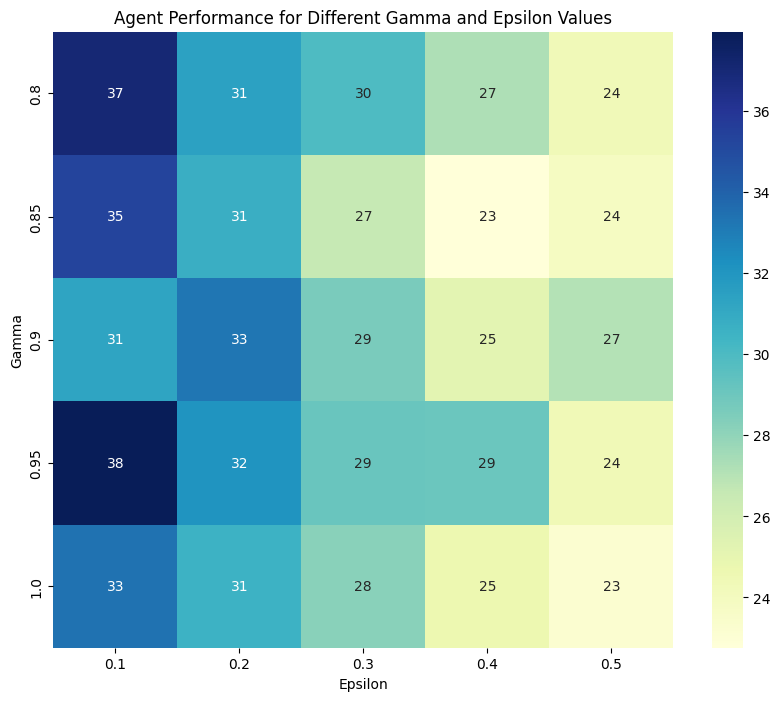

In [7]:
# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(performance_metrics, xticklabels=epsilons, yticklabels=gammas, annot=True, cmap="YlGnBu")
plt.xlabel('Epsilon')
plt.ylabel('Gamma')
plt.title('Agent Performance for Different Gamma and Epsilon Values')

plot_file_path = "../reports/figures/sensitivity_analysis_mc_screen.png"
plt.savefig(plot_file_path)

#### *Best params training*

In [8]:
# Get best hyper param epsilon and gamma
# Find the position of the maximum value in the performance metrics matrix
max_value_index = np.unravel_index(performance_metrics.argmax(), performance_metrics.shape)

# Retrieve the corresponding epsilon and gamma values
best_epsilon = epsilons[max_value_index[1]]  # Column index for epsilon
best_gamma = gammas[max_value_index[0]]  # Row index for gamma

# Train
trained_agent, episode_rewards = train_monte_carlo_agent('TextFlappyBird-screen-v0', episodes=25000, gamma=best_gamma, epsilon=best_epsilon)

# Save agent and episode reward history
episode_rewards_df = pd.DataFrame(episode_rewards, columns=["Reward"])
episode_rewards_df.to_csv('../saves/episode_rewards_mc_screen.csv', index_label="Episode")

with open('../agents/mc-agent-screen.pkl', 'wb') as f:
    pickle.dump(trained_agent, f)

Training process: 100%|██████████| 25000/25000 [45:12<00:00,  9.22it/s]


Training completed.


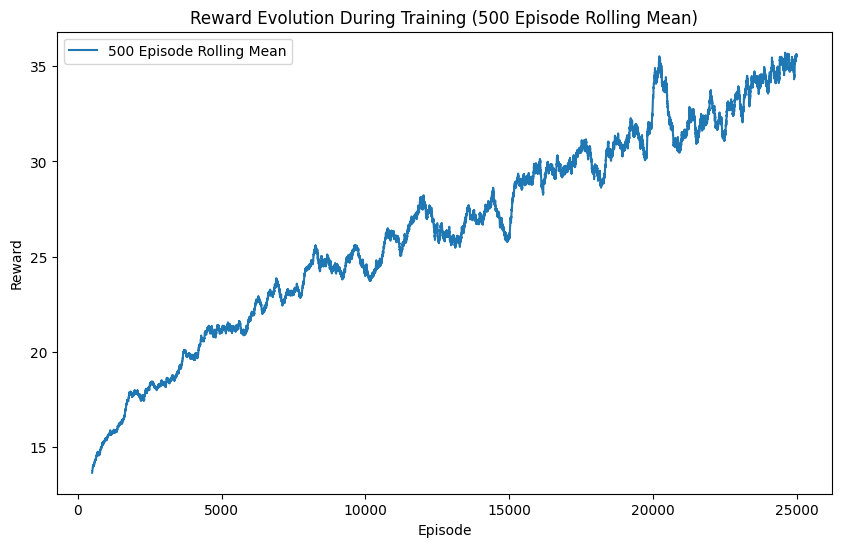

In [9]:
# Calculate the rolling mean
rolling_mean = episode_rewards_df['Reward'].rolling(window=500).mean()

# Plot the rolling mean of reward evolution during training
plt.figure(figsize=(10, 6))
sns.lineplot(data=rolling_mean, label='500 Episode Rolling Mean')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Evolution During Training (500 Episode Rolling Mean)')
plt.legend()
plt.savefig('../reports/figures/reward_evolution_rolling_mean_mc_screen.png')
plt.show()

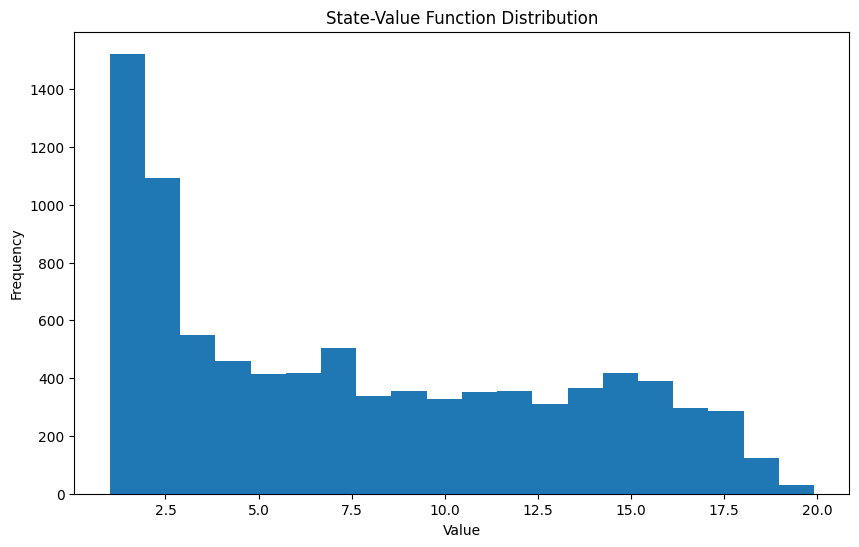

In [10]:
state_value_function = trained_agent.get_state_value_function()

values = list(state_value_function.values())

plt.figure(figsize=(10, 6))
plt.hist(values, bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('State-Value Function Distribution')
plt.savefig('../reports/figures/state_value_function_mc_screen.png')
plt.show()

### **Text Flappy Bird Dist Env**

#### *Sensitivity analysis*
Conducted over 1000 episodes, the goal is to check the sensitivity of different hyperparameters to be able to find optimal ones.

In [11]:
gammas = [0.8, 0.85, 0.9, 0.95, 1.0]  # Gamma values
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]  # Epsilon values
performance_metrics = np.zeros((len(gammas), len(epsilons)))

In [12]:
for i, gamma in enumerate(gammas):
    for j, epsilon in enumerate(epsilons):
        trained_agent, episode_rewards = train_monte_carlo_agent('TextFlappyBird-v0', episodes=7000, gamma=gamma, epsilon=epsilon)
        total_reward = test_agent(trained_agent, episodes=100)
        performance_metrics[i, j] = total_reward

Training process: 100%|██████████| 7000/7000 [00:36<00:00, 191.36it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 47.96it/s]


Total reward across all episodes:  245078
Average Reward over 100 episodes: 2450.78


Training process: 100%|██████████| 7000/7000 [00:30<00:00, 230.15it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 299.81it/s]


Total reward across all episodes:  38890
Average Reward over 100 episodes: 388.9


Training process: 100%|██████████| 7000/7000 [00:27<00:00, 253.78it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 691.98it/s]


Total reward across all episodes:  16331
Average Reward over 100 episodes: 163.31


Training process: 100%|██████████| 7000/7000 [00:26<00:00, 264.38it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 609.61it/s]


Total reward across all episodes:  19096
Average Reward over 100 episodes: 190.96


Training process: 100%|██████████| 7000/7000 [00:25<00:00, 272.48it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 1298.54it/s]


Total reward across all episodes:  8914
Average Reward over 100 episodes: 89.14


Training process: 100%|██████████| 7000/7000 [00:38<00:00, 181.88it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 311.96it/s]


Total reward across all episodes:  37410
Average Reward over 100 episodes: 374.1


Training process: 100%|██████████| 7000/7000 [00:31<00:00, 222.08it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 60.67it/s]


Total reward across all episodes:  192498
Average Reward over 100 episodes: 1924.98


Training process: 100%|██████████| 7000/7000 [00:27<00:00, 250.16it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 241.49it/s]


Total reward across all episodes:  48640
Average Reward over 100 episodes: 486.4


Training process: 100%|██████████| 7000/7000 [00:26<00:00, 266.35it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 268.75it/s]


Total reward across all episodes:  43370
Average Reward over 100 episodes: 433.7


Training process: 100%|██████████| 7000/7000 [00:25<00:00, 271.57it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 196.23it/s]


Total reward across all episodes:  59100
Average Reward over 100 episodes: 591.0


Training process: 100%|██████████| 7000/7000 [00:39<00:00, 177.24it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Total reward across all episodes:  1000100
Average Reward over 100 episodes: 10001.0


Training process: 100%|██████████| 7000/7000 [00:30<00:00, 231.90it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 80.44it/s]


Total reward across all episodes:  144618
Average Reward over 100 episodes: 1446.18


Training process: 100%|██████████| 7000/7000 [00:28<00:00, 247.75it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 515.39it/s]


Total reward across all episodes:  22528
Average Reward over 100 episodes: 225.28


Training process: 100%|██████████| 7000/7000 [00:26<00:00, 264.73it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 318.38it/s]


Total reward across all episodes:  36650
Average Reward over 100 episodes: 366.5


Training process: 100%|██████████| 7000/7000 [00:25<00:00, 271.76it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 389.79it/s]


Total reward across all episodes:  29980
Average Reward over 100 episodes: 299.8


Training process: 100%|██████████| 7000/7000 [00:36<00:00, 191.14it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 74.37it/s]


Total reward across all episodes:  158389
Average Reward over 100 episodes: 1583.89


Training process: 100%|██████████| 7000/7000 [00:30<00:00, 231.87it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 192.46it/s]


Total reward across all episodes:  60550
Average Reward over 100 episodes: 605.5


Training process: 100%|██████████| 7000/7000 [00:28<00:00, 249.95it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 483.02it/s]


Total reward across all episodes:  23888
Average Reward over 100 episodes: 238.88


Training process: 100%|██████████| 7000/7000 [00:26<00:00, 262.95it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 865.70it/s]


Total reward across all episodes:  13446
Average Reward over 100 episodes: 134.46


Training process: 100%|██████████| 7000/7000 [00:25<00:00, 276.59it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 1818.19it/s]


Total reward across all episodes:  6327
Average Reward over 100 episodes: 63.27


Training process: 100%|██████████| 7000/7000 [00:32<00:00, 212.27it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 568.08it/s]


Total reward across all episodes:  20559
Average Reward over 100 episodes: 205.59


Training process: 100%|██████████| 7000/7000 [00:30<00:00, 229.02it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 956.77it/s]


Total reward across all episodes:  12106
Average Reward over 100 episodes: 121.06


Training process: 100%|██████████| 7000/7000 [00:26<00:00, 260.86it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 1004.76it/s]


Total reward across all episodes:  11542
Average Reward over 100 episodes: 115.42


Training process: 100%|██████████| 7000/7000 [00:26<00:00, 265.90it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 222.67it/s]


Total reward across all episodes:  52160
Average Reward over 100 episodes: 521.6


Training process: 100%|██████████| 7000/7000 [00:25<00:00, 277.85it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 1117.18it/s]

Total reward across all episodes:  10304
Average Reward over 100 episodes: 103.04


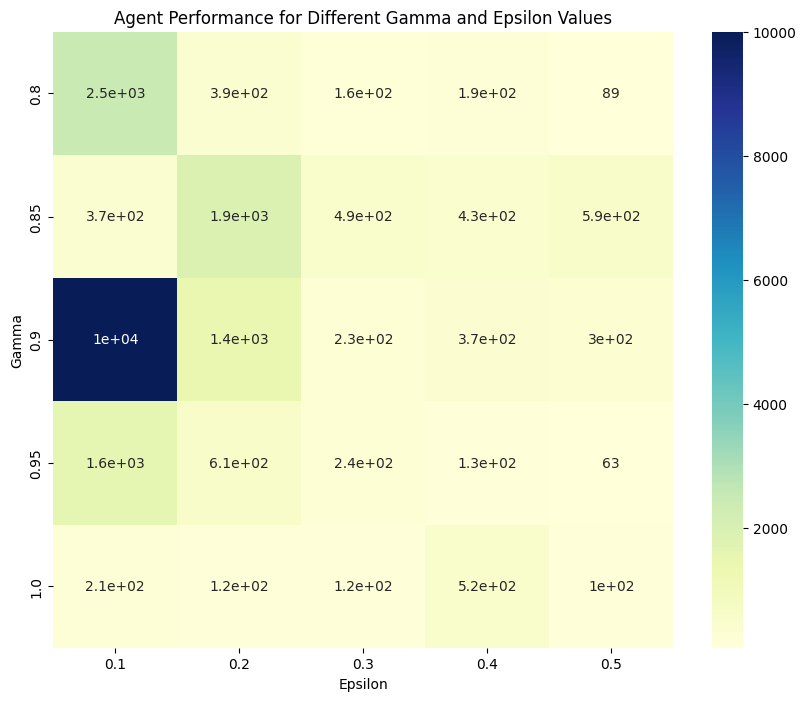

In [13]:
# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(performance_metrics, xticklabels=epsilons, yticklabels=gammas, annot=True, cmap="YlGnBu")
plt.xlabel('Epsilon')
plt.ylabel('Gamma')
plt.title('Agent Performance for Different Gamma and Epsilon Values')

plot_file_path = "../reports/figures/sensitivity_analysis_mc_dist.png"
plt.savefig(plot_file_path)

#### *Best params training*

In [14]:
# Get best hyper param epsilon and gamma
# Find the position of the maximum value in the performance metrics matrix
max_value_index = np.unravel_index(performance_metrics.argmax(), performance_metrics.shape)

# Retrieve the corresponding epsilon and gamma values
best_epsilon = epsilons[max_value_index[1]]  # Column index for epsilon
best_gamma = gammas[max_value_index[0]]  # Row index for gamma

# Train
trained_agent, episode_rewards = train_monte_carlo_agent('TextFlappyBird-v0', episodes=25000, gamma=best_gamma, epsilon=best_epsilon)

# Save agent and episode reward history
episode_rewards_df = pd.DataFrame(episode_rewards, columns=["Reward"])
episode_rewards_df.to_csv('../saves/episode_rewards_mc_dist.csv', index_label="Episode")

with open('../agents/mc-agent-dist.pkl', 'wb') as f:
    pickle.dump(trained_agent, f)

Training process: 100%|██████████| 25000/25000 [02:19<00:00, 178.57it/s]

Training completed.


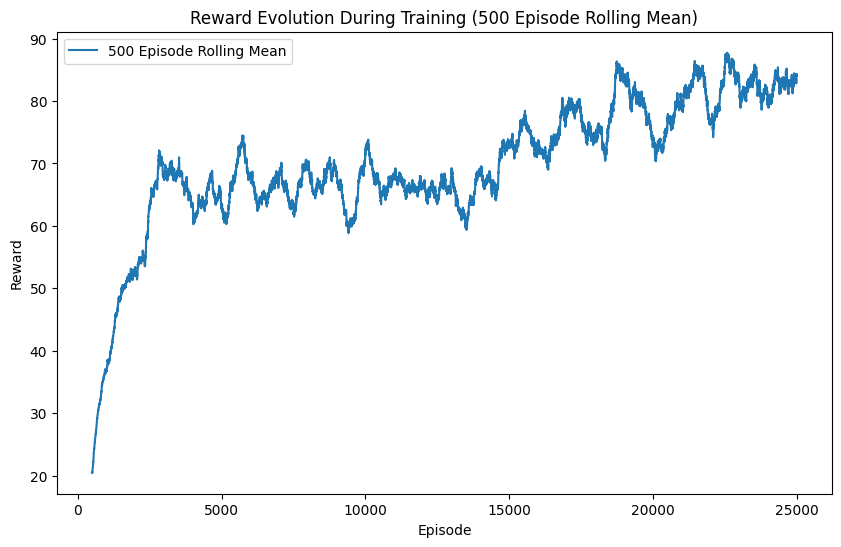

In [15]:
# Calculate the rolling mean
rolling_mean = episode_rewards_df['Reward'].rolling(window=500).mean()

# Plot the rolling mean of reward evolution during training
plt.figure(figsize=(10, 6))
sns.lineplot(data=rolling_mean, label='500 Episode Rolling Mean')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Evolution During Training (500 Episode Rolling Mean)')
plt.legend()
plt.savefig('../reports/figures/reward_evolution_rolling_mean_mc_dist.png')
plt.show()

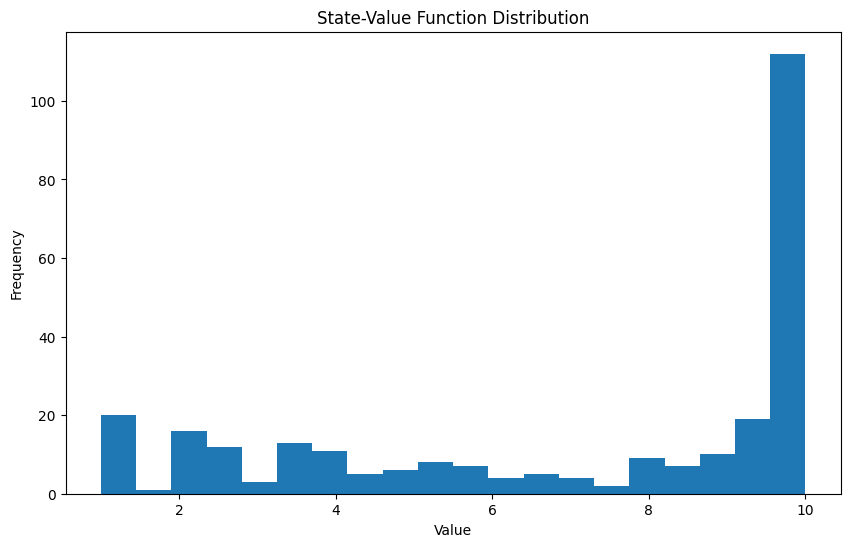

In [16]:
state_value_function = trained_agent.get_state_value_function()

values = list(state_value_function.values())

plt.figure(figsize=(10, 6))
plt.hist(values, bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('State-Value Function Distribution')
plt.savefig('../reports/figures/state_value_function_mc_dist.png')
plt.show()

### **Test of trained agent on different level configuration (check overfitting)**

#### *Test on screen agent*

In [17]:
# Load the trained agent
with open('../agents/mc-agent-screen.pkl', 'rb') as f:
    trained_agent_screen = pickle.load(f)

# Define the configurations to test
configurations = [
    {'height': 15, 'width': 20, 'pipe_gap': 4},
    {'height': 20, 'width': 25, 'pipe_gap': 7},
    {'height': 25, 'width': 33, 'pipe_gap': 10}
]

# Placeholder for average rewards
average_rewards = []

# Test the agent on different configurations and collect average rewards
for config in configurations:
    print(f"Testing on configuration: {config}")
    env = gym.make('TextFlappyBird-screen-v0', height=config['height'], width=config['width'], pipe_gap=config['pipe_gap'])
    trained_agent_screen.env = env
    avg_reward = test_agent(trained_agent_screen, episodes=100, reward_threshold=10000)
    average_rewards.append(avg_reward)
    print(f"Average reward for configuration {config}: {avg_reward}\n")

Testing on configuration: {'height': 15, 'width': 20, 'pipe_gap': 4}


Testing episodes: 100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


Total reward across all episodes:  7273
Average Reward over 100 episodes: 72.73
Average reward for configuration {'height': 15, 'width': 20, 'pipe_gap': 4}: 72.73

Testing on configuration: {'height': 20, 'width': 25, 'pipe_gap': 7}


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 46.72it/s]


Total reward across all episodes:  1511
Average Reward over 100 episodes: 15.11
Average reward for configuration {'height': 20, 'width': 25, 'pipe_gap': 7}: 15.11

Testing on configuration: {'height': 25, 'width': 33, 'pipe_gap': 10}


Testing episodes: 100%|██████████| 100/100 [00:04<00:00, 24.50it/s]

Total reward across all episodes:  1856
Average Reward over 100 episodes: 18.56
Average reward for configuration {'height': 25, 'width': 33, 'pipe_gap': 10}: 18.56



In [18]:
# Create labels for the x-axis
config_labels = [f"Height: {config['height']}, Width: {config['width']}, Pipe Gap: {config['pipe_gap']}" for config in configurations]

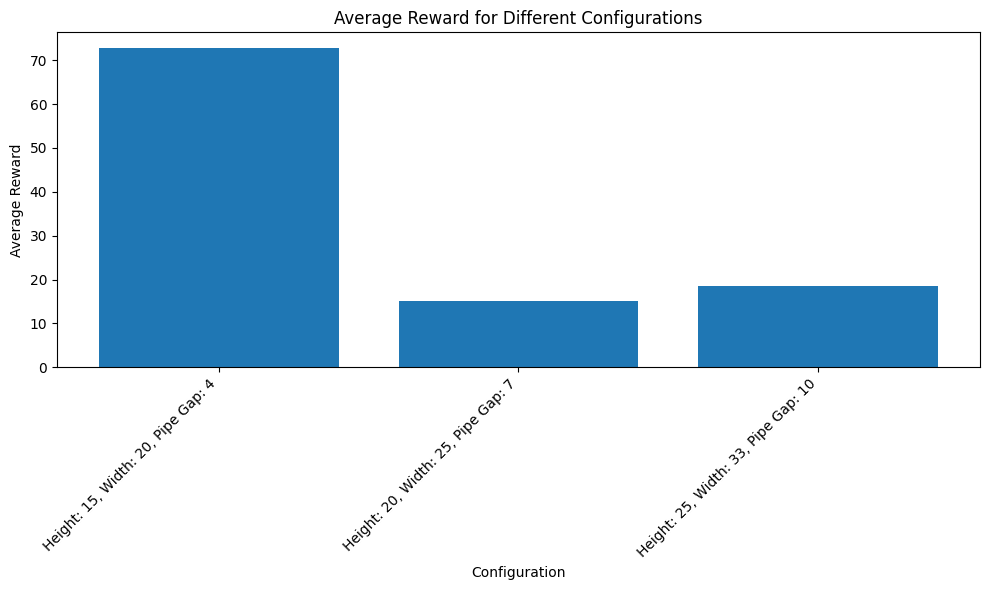

In [19]:
# Create a histogram plot
plt.figure(figsize=(10, 6))
plt.bar(config_labels, average_rewards)
plt.xlabel('Configuration')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Configurations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/average_reward_histogram_mc_screen.png')
plt.show()

#### *Test on dist agent*

In [20]:
# Load the trained agent
with open('../agents/mc-agent-dist.pkl', 'rb') as f:
    trained_agent_dist = pickle.load(f)

# Define the configurations to test
configurations = [
    {'height': 15, 'width': 20, 'pipe_gap': 4},
    {'height': 20, 'width': 25, 'pipe_gap': 7},
    {'height': 25, 'width': 33, 'pipe_gap': 10}
]

# Placeholder for average rewards
average_rewards = []

# Test the agent on different configurations and collect average rewards
for config in configurations:
    print(f"Testing on configuration: {config}")
    env = gym.make('TextFlappyBird-v0', height=config['height'], width=config['width'], pipe_gap=config['pipe_gap'])
    trained_agent_dist.env = env
    avg_reward = test_agent(trained_agent_dist, episodes=100, reward_threshold=10000)
    average_rewards.append(avg_reward)
    print(f"Average reward for configuration {config}: {avg_reward}\n")

Testing on configuration: {'height': 15, 'width': 20, 'pipe_gap': 4}


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 85.40it/s]


Total reward across all episodes:  137240
Average Reward over 100 episodes: 1372.4
Average reward for configuration {'height': 15, 'width': 20, 'pipe_gap': 4}: 1372.4

Testing on configuration: {'height': 20, 'width': 25, 'pipe_gap': 7}


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 392.12it/s]


Total reward across all episodes:  28619
Average Reward over 100 episodes: 286.19
Average reward for configuration {'height': 20, 'width': 25, 'pipe_gap': 7}: 286.19

Testing on configuration: {'height': 25, 'width': 33, 'pipe_gap': 10}


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 1709.07it/s]

Total reward across all episodes:  5603
Average Reward over 100 episodes: 56.03
Average reward for configuration {'height': 25, 'width': 33, 'pipe_gap': 10}: 56.03



In [21]:
# Create labels for the x-axis
config_labels = [f"Height: {config['height']}, Width: {config['width']}, Pipe Gap: {config['pipe_gap']}" for config in configurations]

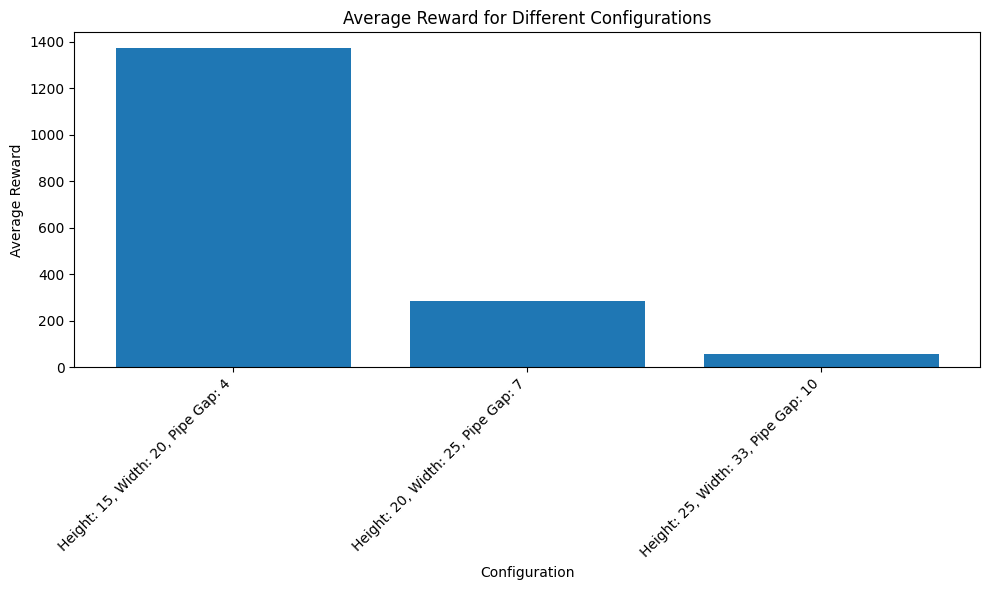

In [22]:
# Create a histogram plot
plt.figure(figsize=(10, 6))
plt.bar(config_labels, average_rewards)
plt.xlabel('Configuration')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Configurations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/average_reward_histogram_mc_dist.png')
plt.show()

---

## **Sarsa based agent**

In [23]:
class SarsaLambdaAgent:
    def __init__(self, env, gamma=0.9, lambda_=0.9, epsilon=0.1, alpha=0.5):
        self.env = env
        self.gamma = gamma
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = defaultdict(self.zero_action_value)
        self.E = defaultdict(self.zero_action_value)

    def zero_action_value(self):
        return np.zeros(self.env.action_space.n)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def update(self, state, action, reward, next_state, next_action, done):
        delta = reward + self.gamma * self.Q[next_state][next_action] * (not done) - self.Q[state][action]
        self.E[state][action] += 1

        for s, values in self.Q.items():
            for a in range(len(values)):
                self.Q[s][a] += self.alpha * delta * self.E[s][a]
                self.E[s][a] *= self.gamma * self.lambda_

    def reset_eligibility_traces(self):
        for s in self.E:
            for a in range(len(self.E[s])):
                self.E[s][a] = 0

    def train(self, num_episodes):
        for i_episode in range(num_episodes):
            state = self.env.reset()
            action = self.choose_action(str(state))
            self.reset_eligibility_traces()
            done = False

            while not done:
                next_state, reward, done, _, _ = self.env.step(action)
                next_action = self.choose_action(str(next_state))
                self.update(str(state), action, reward, str(next_state), next_action, done)
                state = next_state
                action = next_action
    
    def get_state_value_function(self):
        state_value_function = {}
        for state, action_values in self.Q.items():
            state_value_function[state] = np.max(action_values)
        return state_value_function

In [24]:
def train_sarsa_lambda_agent(env_str, episodes=1000, gamma=0.9, lambda_=0.9, epsilon=0.1, alpha=0.5):
    env = gym.make(env_str, height=15, width=20, pipe_gap=4)
    agent = SarsaLambdaAgent(env, gamma=gamma, lambda_=lambda_, epsilon=epsilon, alpha=alpha)
    
    episode_rewards = []

    for _ in tqdm(range(episodes), desc="Training process"):
        state = env.reset()
        action = agent.choose_action(str(state))
        agent.reset_eligibility_traces()
        total_reward = 0
        done = False

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.choose_action(str(next_state))
            
            # Update Q-values based on the transition
            agent.update(str(state), action, reward, str(next_state), next_action, done)
            
            state = next_state
            action = next_action
            total_reward += reward
        
        episode_rewards.append(total_reward)
    
    print("Training completed.")
    return agent, episode_rewards

In [25]:
def test_sarsa_lambda_agent(agent, episodes=100, reward_threshold=10000):
    total_rewards = 0
    episode_scores = []  # To store the score of each episode

    for episode_num in tqdm(range(1, episodes + 1), desc="Testing episodes"):
        state = agent.env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.choose_action(str(state))  # Directly choose action from agent's policy
            
            next_state, reward, done, _, info = agent.env.step(action)
            episode_reward += reward
            state = next_state  # Update the state

            # Check if the reward threshold for this episode has been exceeded
            if episode_reward > reward_threshold:
                break

        # Episode is done or threshold exceeded, append its total reward to episode_scores
        episode_scores.append(episode_reward)
        total_rewards += episode_reward
    
    avg_reward = total_rewards / episodes
    print("Total reward across all episodes: ", total_rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward}")
    return avg_reward

### **Text Flappy Bird Screen env**

#### *Sensitivity analysis*
Conducted over 1000 episodes, the goal is to check the sensitivity of different hyperparameters to be able to find optimal ones.

In [26]:
gammas = [0.8, 1.0]
epsilons = [0.1, 0.5]
lambdas = [0.8, 1.0]
alphas = [0.1, 0.5]

# Create a list of all possible combinations of hyperparameters
param_combinations = list(itertools.product(gammas, epsilons, lambdas, alphas))

In [27]:
# Initialize a list to store the performance results
performance_metrics = []

for gamma, epsilon, lambda_, alpha in param_combinations:
    trained_agent, episode_rewards = train_sarsa_lambda_agent('TextFlappyBird-screen-v0', episodes=7000, gamma=gamma, epsilon=epsilon, lambda_=lambda_, alpha=alpha)
    total_reward = test_sarsa_lambda_agent(trained_agent, episodes=100)
    performance_metrics.append([gamma, epsilon, lambda_, alpha, total_reward])

Training process: 100%|██████████| 7000/7000 [03:29<00:00, 33.49it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 108.27it/s]


Total reward across all episodes:  991
Average Reward over 100 episodes: 9.91


Training process: 100%|██████████| 7000/7000 [08:12<00:00, 14.20it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 75.94it/s]


Total reward across all episodes:  1430
Average Reward over 100 episodes: 14.3


Training process: 100%|██████████| 7000/7000 [03:36<00:00, 32.31it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 101.20it/s]


Total reward across all episodes:  1078
Average Reward over 100 episodes: 10.78


Training process: 100%|██████████| 7000/7000 [09:44<00:00, 11.97it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 79.54it/s]


Total reward across all episodes:  1389
Average Reward over 100 episodes: 13.89


Training process: 100%|██████████| 7000/7000 [18:12<00:00,  6.41it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 74.25it/s]


Total reward across all episodes:  1465
Average Reward over 100 episodes: 14.65


Training process: 100%|██████████| 7000/7000 [23:32<00:00,  4.96it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 67.32it/s]


Total reward across all episodes:  1613
Average Reward over 100 episodes: 16.13


Training process: 100%|██████████| 7000/7000 [18:38<00:00,  6.26it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 73.32it/s]


Total reward across all episodes:  1481
Average Reward over 100 episodes: 14.81


Training process: 100%|██████████| 7000/7000 [23:37<00:00,  4.94it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 69.38it/s]


Total reward across all episodes:  1576
Average Reward over 100 episodes: 15.76


Training process: 100%|██████████| 7000/7000 [03:40<00:00, 31.81it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 104.53it/s]


Total reward across all episodes:  1046
Average Reward over 100 episodes: 10.46


Training process: 100%|██████████| 7000/7000 [09:13<00:00, 12.64it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 67.67it/s]


Total reward across all episodes:  1609
Average Reward over 100 episodes: 16.09


Training process: 100%|██████████| 7000/7000 [05:09<00:00, 22.59it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 90.14it/s]


Total reward across all episodes:  1217
Average Reward over 100 episodes: 12.17


Training process: 100%|██████████| 7000/7000 [11:11<00:00, 10.42it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 74.36it/s]


Total reward across all episodes:  1465
Average Reward over 100 episodes: 14.65


Training process: 100%|██████████| 7000/7000 [19:04<00:00,  6.12it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 66.73it/s]


Total reward across all episodes:  1639
Average Reward over 100 episodes: 16.39


Training process: 100%|██████████| 7000/7000 [23:43<00:00,  4.92it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 64.50it/s]


Total reward across all episodes:  1674
Average Reward over 100 episodes: 16.74


Training process: 100%|██████████| 7000/7000 [21:11<00:00,  5.50it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 68.40it/s]


Total reward across all episodes:  1605
Average Reward over 100 episodes: 16.05


Training process: 100%|██████████| 7000/7000 [24:24<00:00,  4.78it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 69.63it/s]

Total reward across all episodes:  1567
Average Reward over 100 episodes: 15.67


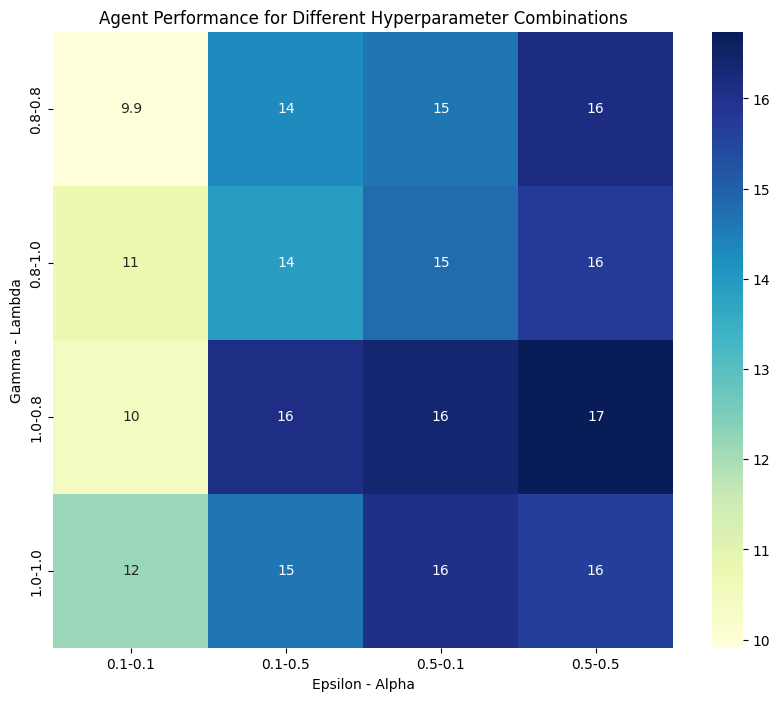

In [28]:
# Create a DataFrame from the results
df = pd.DataFrame(performance_metrics, columns=['Gamma', 'Epsilon', 'Lambda', 'Alpha', 'Total Reward'])

# Pivot the DataFrame to create a multi-index for the heatmap
pivot_df = df.pivot_table(index=['Gamma', 'Lambda'], columns=['Epsilon', 'Alpha'], values='Total Reward')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")
plt.xlabel('Epsilon - Alpha')
plt.ylabel('Gamma - Lambda')
plt.title('Agent Performance for Different Hyperparameter Combinations')
plot_file_path = "../reports/figures/sensitivity_analysis_sarsa_screen.png"
plt.savefig(plot_file_path)

#### *Best params training*

In [29]:
# Get best hyper param epsilon and gamma
# Find the row with the maximum total reward
best_params_row = df.loc[df['Total Reward'].idxmax()]

# Extract the best hyperparameters
best_gamma = best_params_row['Gamma']
best_epsilon = best_params_row['Epsilon']
best_lambda = best_params_row['Lambda']
best_alpha = best_params_row['Alpha']

# Train
trained_agent, episode_rewards = train_sarsa_lambda_agent('TextFlappyBird-screen-v0', episodes=25000, gamma=best_gamma, epsilon=best_epsilon, lambda_=best_lambda, alpha=best_alpha)

# Save agent and episode reward history
episode_rewards_df = pd.DataFrame(episode_rewards, columns=["Reward"])
episode_rewards_df.to_csv('../saves/episode_rewards_sarsa_screen.csv', index_label="Episode")

with open('../agents/sarsa-agent-screen.pkl', 'wb') as f:
    pickle.dump(trained_agent, f)

Training process: 100%|██████████| 25000/25000 [2:50:12<00:00,  2.45it/s]  

Training completed.


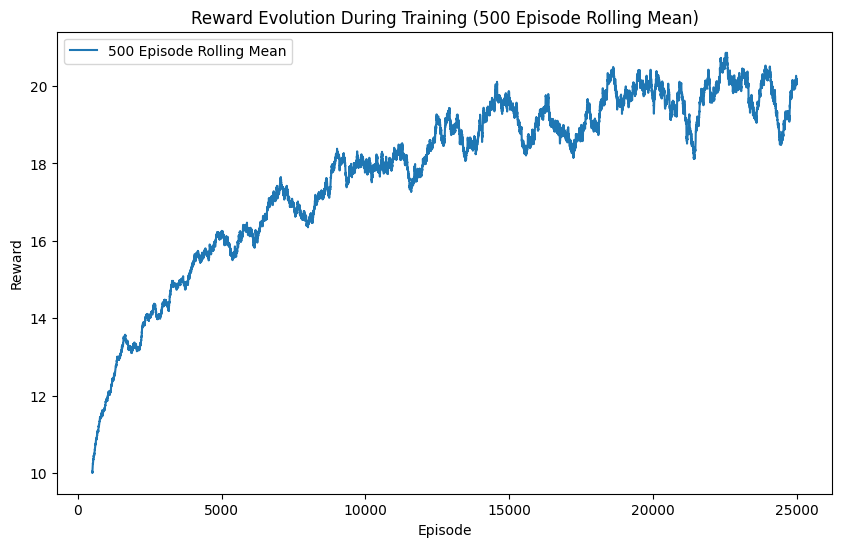

In [30]:
# Calculate the rolling mean
rolling_mean = episode_rewards_df['Reward'].rolling(window=500).mean()

# Plot the rolling mean of reward evolution during training
plt.figure(figsize=(10, 6))
sns.lineplot(data=rolling_mean, label='500 Episode Rolling Mean')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Evolution During Training (500 Episode Rolling Mean)')
plt.legend()
plt.savefig('../reports/figures/reward_evolution_rolling_mean_sarsa_screen.png')
plt.show()

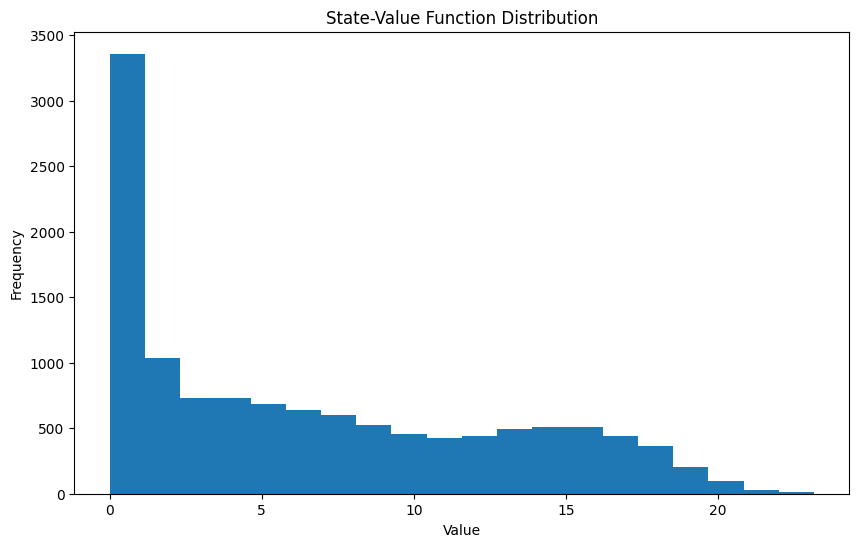

In [31]:
state_value_function = trained_agent.get_state_value_function()

values = list(state_value_function.values())

plt.figure(figsize=(10, 6))
plt.hist(values, bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('State-Value Function Distribution')
plt.savefig('../reports/figures/state_value_function_sarsa_screen.png')
plt.show()

### **Text Flappy Bird dist env**

#### *Sensitivity analysis*
Conducted over 1000 episodes, the goal is to check the sensitivity of different hyperparameters to be able to find optimal ones.

In [32]:
gammas = [0.8, 1.0]
epsilons = [0.1, 0.5]
lambdas = [0.8, 1.0]
alphas = [0.1, 0.5]

# Create a list of all possible combinations of hyperparameters
param_combinations = list(itertools.product(gammas, epsilons, lambdas, alphas))

In [33]:
# Initialize a list to store the performance results
performance_metrics = []

for gamma, epsilon, lambda_, alpha in param_combinations:
    trained_agent, episode_rewards = train_sarsa_lambda_agent('TextFlappyBird-v0', episodes=7000, gamma=gamma, epsilon=epsilon, lambda_=lambda_, alpha=alpha)
    total_reward = test_sarsa_lambda_agent(trained_agent, episodes=100)
    performance_metrics.append([gamma, epsilon, lambda_, alpha, total_reward])

Training process: 100%|██████████| 7000/7000 [00:45<00:00, 153.91it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 1306.95it/s]


Total reward across all episodes:  5666
Average Reward over 100 episodes: 56.66


Training process: 100%|██████████| 7000/7000 [04:30<00:00, 25.86it/s] 


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 836.68it/s]


Total reward across all episodes:  8143
Average Reward over 100 episodes: 81.43


Training process: 100%|██████████| 7000/7000 [01:01<00:00, 114.30it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 1408.41it/s]


Total reward across all episodes:  5698
Average Reward over 100 episodes: 56.98


Training process: 100%|██████████| 7000/7000 [04:14<00:00, 27.53it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 822.93it/s]


Total reward across all episodes:  8080
Average Reward over 100 episodes: 80.8


Training process: 100%|██████████| 7000/7000 [01:35<00:00, 73.10it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 2665.86it/s]


Total reward across all episodes:  2498
Average Reward over 100 episodes: 24.98


Training process: 100%|██████████| 7000/7000 [01:32<00:00, 75.89it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 3333.28it/s]


Total reward across all episodes:  2014
Average Reward over 100 episodes: 20.14


Training process: 100%|██████████| 7000/7000 [01:34<00:00, 73.87it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 2702.67it/s]


Total reward across all episodes:  2416
Average Reward over 100 episodes: 24.16


Training process: 100%|██████████| 7000/7000 [01:27<00:00, 79.77it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 3388.32it/s]


Total reward across all episodes:  1954
Average Reward over 100 episodes: 19.54


Training process: 100%|██████████| 7000/7000 [02:06<00:00, 55.32it/s] 


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 668.80it/s]


Total reward across all episodes:  10031
Average Reward over 100 episodes: 100.31


Training process: 100%|██████████| 7000/7000 [04:38<00:00, 25.12it/s] 


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 877.05it/s]


Total reward across all episodes:  9009
Average Reward over 100 episodes: 90.09


Training process: 100%|██████████| 7000/7000 [01:38<00:00, 71.34it/s] 


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 2127.66it/s]


Total reward across all episodes:  3140
Average Reward over 100 episodes: 31.4


Training process: 100%|██████████| 7000/7000 [01:07<00:00, 104.42it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 4874.09it/s]


Total reward across all episodes:  1302
Average Reward over 100 episodes: 13.02


Training process: 100%|██████████| 7000/7000 [01:39<00:00, 70.34it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 3030.33it/s]


Total reward across all episodes:  2158
Average Reward over 100 episodes: 21.58


Training process: 100%|██████████| 7000/7000 [01:30<00:00, 77.01it/s] 


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 3571.50it/s]


Total reward across all episodes:  1892
Average Reward over 100 episodes: 18.92


Training process: 100%|██████████| 7000/7000 [01:33<00:00, 75.16it/s]


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 3124.11it/s]


Total reward across all episodes:  2097
Average Reward over 100 episodes: 20.97


Training process: 100%|██████████| 7000/7000 [01:17<00:00, 90.53it/s] 


Training completed.


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 3703.74it/s]

Total reward across all episodes:  1828
Average Reward over 100 episodes: 18.28


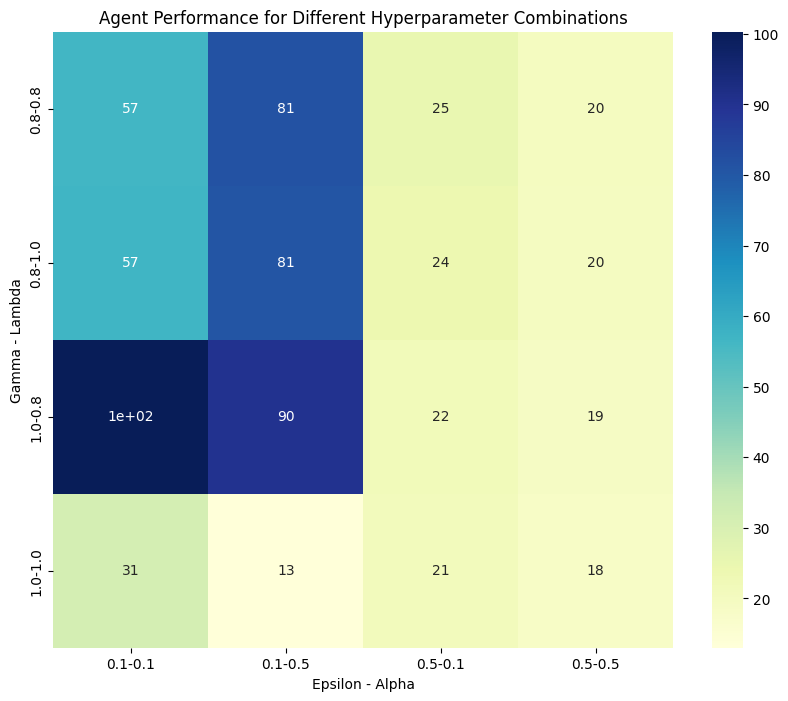

In [34]:
# Create a DataFrame from the results
df = pd.DataFrame(performance_metrics, columns=['Gamma', 'Epsilon', 'Lambda', 'Alpha', 'Total Reward'])

# Pivot the DataFrame to create a multi-index for the heatmap
pivot_df = df.pivot_table(index=['Gamma', 'Lambda'], columns=['Epsilon', 'Alpha'], values='Total Reward')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")
plt.xlabel('Epsilon - Alpha')
plt.ylabel('Gamma - Lambda')
plt.title('Agent Performance for Different Hyperparameter Combinations')
plot_file_path = "../reports/figures/sensitivity_analysis_sarsa_dist.png"
plt.savefig(plot_file_path)

In [35]:
# Get best hyper param epsilon and gamma
# Find the row with the maximum total reward
best_params_row = df.loc[df['Total Reward'].idxmax()]

# Extract the best hyperparameters
best_gamma = best_params_row['Gamma']
best_epsilon = best_params_row['Epsilon']
best_lambda = best_params_row['Lambda']
best_alpha = best_params_row['Alpha']

# Train
trained_agent, episode_rewards = train_sarsa_lambda_agent('TextFlappyBird-v0', episodes=25000, gamma=best_gamma, epsilon=best_epsilon, lambda_=best_lambda, alpha=best_alpha)

# Save agent and episode reward history
episode_rewards_df = pd.DataFrame(episode_rewards, columns=["Reward"])
episode_rewards_df.to_csv('../saves/episode_rewards_sarsa_dist.csv', index_label="Episode")

with open('../agents/sarsa-agent-dist.pkl', 'wb') as f:
    pickle.dump(trained_agent, f)

Training process: 100%|██████████| 25000/25000 [22:58<00:00, 18.13it/s]

Training completed.


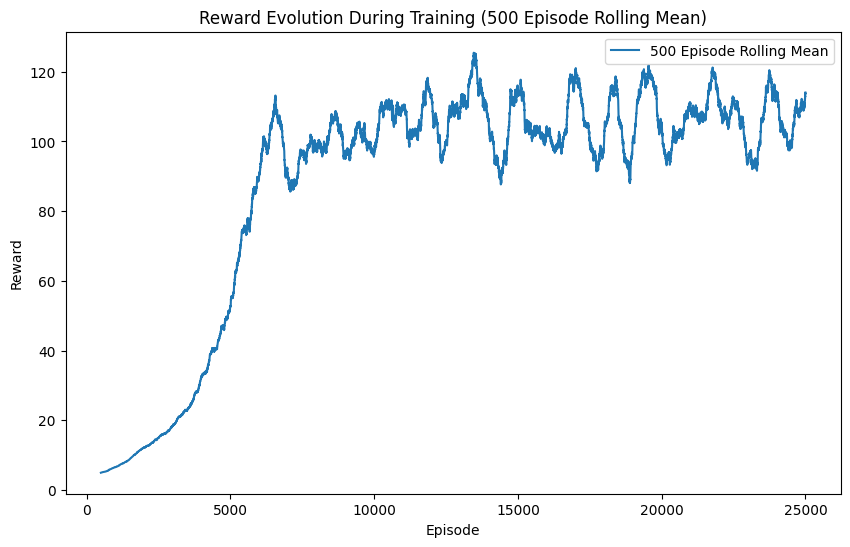

In [36]:
# Calculate the rolling mean
rolling_mean = episode_rewards_df['Reward'].rolling(window=500).mean()

# Plot the rolling mean of reward evolution during training
plt.figure(figsize=(10, 6))
sns.lineplot(data=rolling_mean, label='500 Episode Rolling Mean')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Evolution During Training (500 Episode Rolling Mean)')
plt.legend()
plt.savefig('../reports/figures/reward_evolution_rolling_mean_sarsa_dist.png')
plt.show()

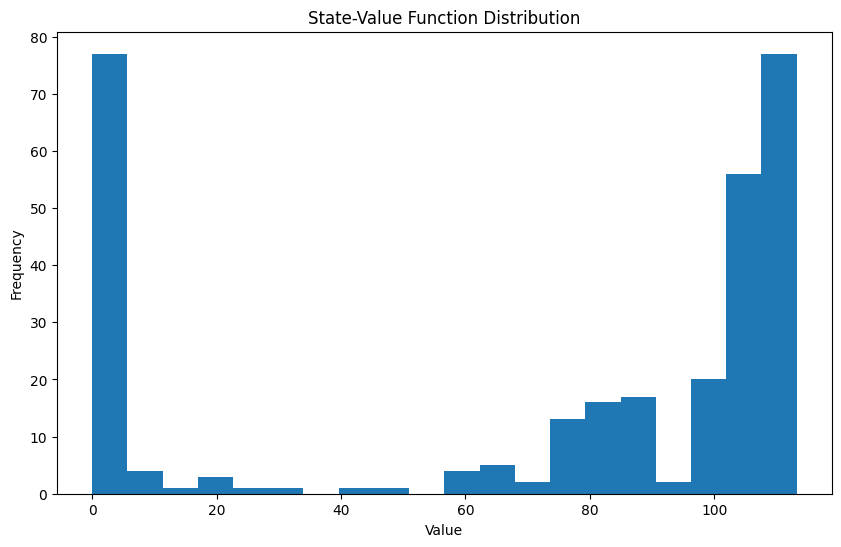

In [37]:
state_value_function = trained_agent.get_state_value_function()

values = list(state_value_function.values())

plt.figure(figsize=(10, 6))
plt.hist(values, bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('State-Value Function Distribution')
plt.savefig('../reports/figures/state_value_function_sarsa_dist.png')
plt.show()

### **Test of trained agent on different level configuration (check overfitting)**

#### *Test on screen agent*

In [38]:
# Load the trained agent
with open('../agents/sarsa-agent-screen.pkl', 'rb') as f:
    trained_agent_screen = pickle.load(f)

# Define the configurations to test
configurations = [
    {'height': 15, 'width': 20, 'pipe_gap': 4},
    {'height': 20, 'width': 25, 'pipe_gap': 7},
    {'height': 25, 'width': 33, 'pipe_gap': 10}
]

# Placeholder for average rewards
average_rewards = []

# Test the agent on different configurations and collect average rewards
for config in configurations:
    print(f"Testing on configuration: {config}")
    env = gym.make('TextFlappyBird-screen-v0', height=config['height'], width=config['width'], pipe_gap=config['pipe_gap'])
    trained_agent_screen.env = env
    avg_reward = test_sarsa_lambda_agent(trained_agent_screen, episodes=100, reward_threshold=10000)
    average_rewards.append(avg_reward)
    print(f"Average reward for configuration {config}: {avg_reward}\n")

Testing on configuration: {'height': 15, 'width': 20, 'pipe_gap': 4}


Testing episodes: 100%|██████████| 100/100 [00:02<00:00, 48.80it/s]


Total reward across all episodes:  2233
Average Reward over 100 episodes: 22.33
Average reward for configuration {'height': 15, 'width': 20, 'pipe_gap': 4}: 22.33

Testing on configuration: {'height': 20, 'width': 25, 'pipe_gap': 7}


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 90.22it/s]


Total reward across all episodes:  760
Average Reward over 100 episodes: 7.6
Average reward for configuration {'height': 20, 'width': 25, 'pipe_gap': 7}: 7.6

Testing on configuration: {'height': 25, 'width': 33, 'pipe_gap': 10}


Testing episodes: 100%|██████████| 100/100 [00:01<00:00, 55.79it/s]

Total reward across all episodes:  794
Average Reward over 100 episodes: 7.94
Average reward for configuration {'height': 25, 'width': 33, 'pipe_gap': 10}: 7.94



In [39]:
# Create labels for the x-axis
config_labels = [f"Height: {config['height']}, Width: {config['width']}, Pipe Gap: {config['pipe_gap']}" for config in configurations]

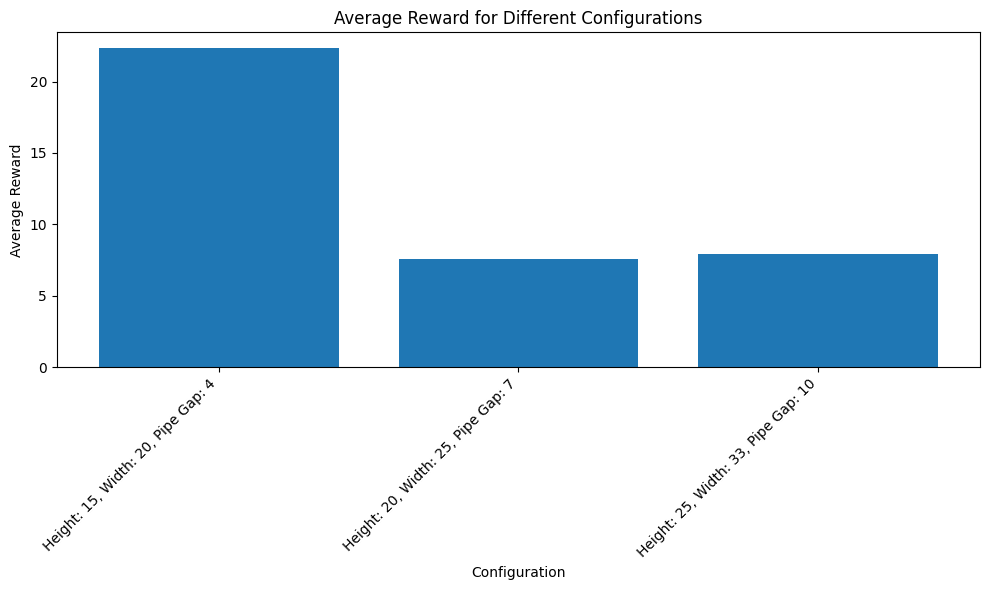

In [40]:
# Create a histogram plot
plt.figure(figsize=(10, 6))
plt.bar(config_labels, average_rewards)
plt.xlabel('Configuration')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Configurations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/average_reward_histogram_sarsa_screen.png')
plt.show()

#### *Test on dist agent*

In [41]:
# Load the trained agent
with open('../agents/sarsa-agent-dist.pkl', 'rb') as f:
    trained_agent_dist = pickle.load(f)

# Define the configurations to test
configurations = [
    {'height': 15, 'width': 20, 'pipe_gap': 4},
    {'height': 20, 'width': 25, 'pipe_gap': 7},
    {'height': 25, 'width': 33, 'pipe_gap': 10}
]

# Placeholder for average rewards
average_rewards = []

# Test the agent on different configurations and collect average rewards
for config in configurations:
    print(f"Testing on configuration: {config}")
    env = gym.make('TextFlappyBird-v0', height=config['height'], width=config['width'], pipe_gap=config['pipe_gap'])
    trained_agent_dist.env = env
    avg_reward = test_sarsa_lambda_agent(trained_agent_dist, episodes=100, reward_threshold=10000)
    average_rewards.append(avg_reward)
    print(f"Average reward for configuration {config}: {avg_reward}\n")

Testing on configuration: {'height': 15, 'width': 20, 'pipe_gap': 4}


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 557.02it/s]


Total reward across all episodes:  13265
Average Reward over 100 episodes: 132.65
Average reward for configuration {'height': 15, 'width': 20, 'pipe_gap': 4}: 132.65

Testing on configuration: {'height': 20, 'width': 25, 'pipe_gap': 7}


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 11111.33it/s]


Total reward across all episodes:  445
Average Reward over 100 episodes: 4.45
Average reward for configuration {'height': 20, 'width': 25, 'pipe_gap': 7}: 4.45

Testing on configuration: {'height': 25, 'width': 33, 'pipe_gap': 10}


Testing episodes: 100%|██████████| 100/100 [00:00<00:00, 9901.33it/s]

Total reward across all episodes:  551
Average Reward over 100 episodes: 5.51
Average reward for configuration {'height': 25, 'width': 33, 'pipe_gap': 10}: 5.51



In [42]:
# Create labels for the x-axis
config_labels = [f"Height: {config['height']}, Width: {config['width']}, Pipe Gap: {config['pipe_gap']}" for config in configurations]

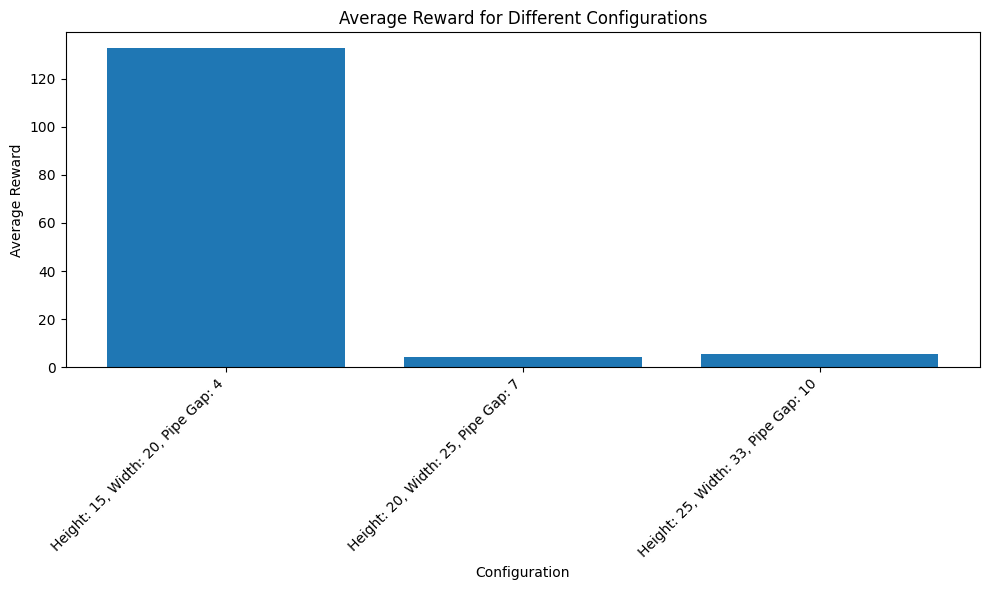

In [43]:
# Create a histogram plot
plt.figure(figsize=(10, 6))
plt.bar(config_labels, average_rewards)
plt.xlabel('Configuration')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Configurations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/average_reward_histogram_sarsa_dist.png')
plt.show()